In [1]:
import numpy as np

import h5py

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

from colossus.cosmology import cosmology
from colossus.lss import mass_function
from colossus.halo import concentration

from scipy.interpolate import interp1d, griddata
from scipy.integrate import simps, quad, trapz, dblquad
from scipy.optimize import root
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

# On the statistical relation between the halo mass function and the internal structure of dark matter haloes
## Associated codes

This notebook aims at providing base codes to perform the transformations of the halo mass function and sparsity predictions presented in Richardson & Corasaniti (2023) [https://arxiv.org/abs/2212.03233 ], any equation/figure numbers referenced here can be found in this publication. These codes are made free to use by the community under the condition that any publication that makes use of these codes considers citing the associated publication. That would be really cool, Thanks a bunch!

# HMF and sparsity data

The data in the hdf5 files associated to this notebook is extracted from the Uchuu simulation (Ishiyama et al. 2021) [https://arxiv.org/abs/2007.14720 ]. The halo catalogues from which the data is produced can be found on the skies and universes database http://skiesanduniverses.org/Simulations/Uchuu/ which we highly recommend visiting. If you want to use any of this data please consider acknowledging the simulations by adding this acknowledgement to your work:

"We thank Instituto de Astrofisica de Andalucia (IAA-CSIC), Centro de Supercomputacion de Galicia (CESGA) and the Spanish academic and research network (RedIRIS) in Spain for hosting Uchuu DR1 and DR2 in the Skies & Universes site for cosmological simulations. The Uchuu simulations were carried out on Aterui II supercomputer at Center for Computational Astrophysics, CfCA, of National Astronomical Observatory of Japan, and the K computer at the RIKEN Advanced Institute for Computational Science. The Uchuu DR1 and DR2 effort has made use of the skun@IAA_RedIRIS and skun6@IAA computer facilities managed by the IAA-CSIC in Spain (MICINN EU-Feder grant EQC2018-004366-P)."

And optionally

"We thank Tamara R.G. Richardson for providing her measurements of the halo mass function and sparsity distributions from the Uchuu simulation used within this work."

Now let's get down to business... First let's read in all of this data.

In [2]:
# We first set up a Planck 2015 cosmology used for the Uchuu simulation

H0 = 67.74
h = H0/100
Om = 0.3089
OL = 0.6911
Ok = 1 - Om - OL
Ob = 0.0486
ns = 0.9667
sig8 = 0.8159
G = 4.3009173e-9 #Mpc*km^2/(s^2*solMass)
Lbox = 2000.

params = {'flat': True, 'H0': H0, 'Om0': Om, 'Ob0': Ob, 'sigma8': sig8, 'ns': ns}
cosmo = cosmology.setCosmology('myCosmo', interpolation = True, persistence = '', **params)

z0p00


Text(0, 0.5, '$s_{200,2500}$')

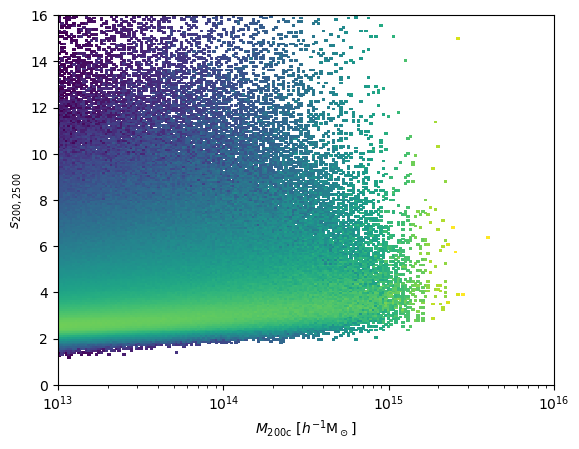

In [3]:
def Uchuu_z_key(z):
    '''
    Function transforming a float snapshot redhift into the corresponding key string used within the Uchuu simulation.
    
    Parameters:
    ----------
    z: (float) Snapshot redshift
    
    Outputs:
    ----------
    zf: (str) Key inside file
    '''
    zf = 'z'+str(z).replace('.', 'p')
    while len(zf)<5:
        zf += '0'
    if len(zf) > 5:
        if int(zf[5]) > 4:
            zf = zf[:4] + str(int(zf[4]) + 1) +zf[5:]
        zf = zf[:5]
    return zf

# The sparsity distributions and halo mass functions in the files have been computed for all snapshots up to z = 2
# Here you can select whichever snapshot you want. Here we'll just look at redshift 0
snap_ind = 0
zs = np.array([0.   , 0.022, 0.045, 0.093, 0.14 , 0.19 , 0.25 , 0.3  , 0.36 ,
               0.43 , 0.49 , 0.56 , 0.63 , 0.7  , 0.78 , 0.86 , 0.94 , 1.03 ,
               1.12 , 1.22 , 1.32 , 1.43 , 1.54 , 1.65 , 1.77 , 1.9  , 2.03 ])
zf = Uchuu_z_key(zs[snap_ind])
print(zf)

hmf_file = "Uchuu_hmf.hdf5"
sparsity_file = "Uchuu_sparsity_distributions.hdf5"

with h5py.File(hmf_file,'r') as f:    
    hmf_200 = f[f'M200c/z{zs[snap_ind]}/hmf'][:]
    bins_200 = f[f'M200c/z{zs[snap_ind]}/mbins'][:]
    err_200 = f[f'M200c/z{zs[snap_ind]}/err'][:]
    
    hmf_500 = f[f'M500c/z{zs[snap_ind]}/hmf'][:]
    bins_500 = f[f'M500c/z{zs[snap_ind]}/mbins'][:]
    err_500 = f[f'M500c/z{zs[snap_ind]}/err'][:]
    
    hmf_2500 = f[f'M2500c/z{zs[snap_ind]}/hmf'][:]
    bins_2500 = f[f'M2500c/z{zs[snap_ind]}/mbins'][:]
    err_2500 = f[f'M2500c/z{zs[snap_ind]}/err'][:]
    
with h5py.File(sparsity_file,'r') as f:
    # So the naming convention is a bit weird but basically you replace most symbols with "_" and divide the numbers by 100... and call it map for some reason
    # These are the conditional sparsity distributions.
    map_s_2_5_2 = f[f"/z{zs[snap_ind]}/distributions/rho(s_200,500|M_200)"][:]
    map_s_2_25_2 = f[f"/z{zs[snap_ind]}/distributions/rho(s_200,2500|M_200)"][:]

    map_s_2_5_5 = f[f"/z{zs[snap_ind]}/distributions/rho(s_200,500|M_500)"][:]
    map_s_5_25_5 = f[f"/z{zs[snap_ind]}/distributions/rho(s_500,2500|M_500)"][:]

    map_s_2_25_25 = f[f"/z{zs[snap_ind]}/distributions/rho(s_200,2500|M_2500)"][:]
    map_s_5_25_25 = f[f"/z{zs[snap_ind]}/distributions/rho(s_500,2500|M_2500)"][:]
    
    s_bins = f[f"/z{zs[snap_ind]}/bins/s"][:]
    M_bins = f[f"/z{zs[snap_ind]}/bins/M"][:]
    
    #This is where the notation breaks down a bit... Here we have the marginalised distributions.
    rho_s = f[f"/z{zs[snap_ind]}/distributions/rho(s_200,500)"][:]
    rho_s2 = f[f"/z{zs[snap_ind]}/distributions/rho(s_200,2500)"][:]
    rho_s3 = f[f"/z{zs[snap_ind]}/distributions/rho(s_500,2500)"][:]
    
plt.pcolormesh(M_bins, s_bins, np.log10(map_s_2_25_2.T))
plt.xscale('log')
plt.xlabel(r'$M_{200\mathrm{c}}\ [h^{-1}\mathrm{M}_\odot]$')
plt.ylabel(r'$s_{200,2500}$')

In [4]:
# Here we just set up the interpolation of the numerical estimates of the marginal distributions.
# We keep it at linear order in log space. Note that the distributions are defined at the centre of the grid and so we define the central points of the 1D and 2D grids

s_bins_cent = .5*(s_bins[1:] + s_bins[:-1])
M_bins_cent = .5*(M_bins[1:] + M_bins[:-1])
M_grid, s_grid = np.meshgrid(0.5*(M_bins[1:]+M_bins[:-1]),0.5*(s_bins[1:]+s_bins[:-1])) 
points = np.stack([s_grid.flatten(), np.log10(M_grid).flatten()]).T


dn_dM = interp1d(np.log10(bins_200), np.log10(hmf_200) - np.log10(bins_200), kind='linear', fill_value = -60, bounds_error = False)
dn_dM500 = interp1d(np.log10(bins_500), np.log10(hmf_500) - np.log10(bins_500), kind='linear', fill_value = -60, bounds_error = False)
dn_dM2500 = interp1d(np.log10(bins_2500), np.log10(hmf_2500) - np.log10(bins_2500), kind='linear', fill_value = -60, bounds_error = False)

pdf_s = interp1d(np.log10(s_bins_cent), np.log10(rho_s), kind = 'linear', fill_value = -15, bounds_error = False)
pdf_s2 = interp1d(np.log10(s_bins_cent), np.log10(rho_s2), kind = 'linear', fill_value = -15, bounds_error = False)
pdf_s3 = interp1d(np.log10(s_bins_cent), np.log10(rho_s3), kind = 'linear', fill_value = -15, bounds_error = False)



# Sparsity based transformations

In [5]:
%%time

# naming scheme 1 dn/dm200
#               2 dn/dm500
#               3 dn/dm2500
# Here 1to2 means dn/dm200 to dn/dm500
# ind means that we're assuming independence thus using the marginal sparsity distribution.

y = np.logspace(0,1, 1000)
z1 = bins_200
z2 = bins_500
z3 = bins_2500

rho_1to2_ind = np.zeros(z1.size)
rho_1to2 = np.zeros(z1.size)
rho_1to3_ind = np.zeros(z1.size)
rho_1to3 = np.zeros(z1.size)
rho_2to3_ind = np.zeros(z1.size)
rho_2to3 = np.zeros(z1.size)
rho_2to1_ind = np.zeros(z1.size)
rho_2to1 = np.zeros(z1.size)
rho_3to1_ind = np.zeros(z1.size)
rho_3to1 = np.zeros(z1.size)
rho_3to2_ind = np.zeros(z1.size)
rho_3to2 = np.zeros(z1.size)

# Beyond the mathmatical notation for variable names... Here we are simply calculating Eq. (4) and (5) 

for i in tqdm(range(len(z1))):
    rho_1to2_ind[i] =  simps( y* 10**(pdf_s(np.log10(y))+dn_dM(np.log10(z2[i]*y))),y)
    rho_1to3_ind[i] =  simps( y* 10**(pdf_s2(np.log10(y))+dn_dM(np.log10(z3[i]*y))),y)
    rho_2to3_ind[i] =  simps( y* 10**(pdf_s3(np.log10(y))+dn_dM500(np.log10(z3[i]*y))),y)
    
    rho_2to1_ind[i] =  simps( 1/y* 10**(pdf_s(np.log10(y))+dn_dM500(np.log10(z1[i]/y))),y)
    rho_3to1_ind[i] =  simps( 1/y* 10**(pdf_s2(np.log10(y))+dn_dM2500(np.log10(z1[i]/y))),y)
    rho_3to2_ind[i] =  simps( 1/y* 10**(pdf_s3(np.log10(y))+dn_dM2500(np.log10(z2[i]/y))),y)

    rho_s_cond = griddata(points, map_s_2_5_2.T.flatten(), (y, np.log10(z2[i]*y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_1to2[i] =  simps( y*rho_s_cond* 10**(dn_dM(np.log10(z2[i]*y))),y)
    
    rho_s_cond = griddata(points, map_s_2_25_2.T.flatten(), (y, np.log10(z3[i]*y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_1to3[i] =  simps( y*rho_s_cond* 10**(dn_dM(np.log10(z3[i]*y))),y)
    
    rho_s_cond = griddata(points, map_s_5_25_5.T.flatten(), (y, np.log10(z3[i]*y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_2to3[i] =  simps( y*rho_s_cond* 10**(dn_dM500(np.log10(z3[i]*y))),y)
    
    rho_s_cond = griddata(points, map_s_2_5_5.T.flatten(), (y, np.log10(z1[i]/y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_2to1[i] =  simps( 1/y*rho_s_cond* 10**(dn_dM500(np.log10(z1[i]/y))),y)
    
    rho_s_cond = griddata(points, map_s_2_25_25.T.flatten(), (y, np.log10(z1[i]/y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_3to1[i] =  simps( 1/y*rho_s_cond* 10**(dn_dM2500(np.log10(z1[i]/y))),y)
    
    rho_s_cond = griddata(points, map_s_5_25_25.T.flatten(), (y, np.log10(z2[i]/y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_3to2[i] =  simps( 1/y*rho_s_cond* 10**(dn_dM2500(np.log10(z2[i]/y))),y)
    
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [05:31<00:00,  8.51s/it]

CPU times: user 6min 21s, sys: 2min 1s, total: 8min 22s
Wall time: 5min 31s


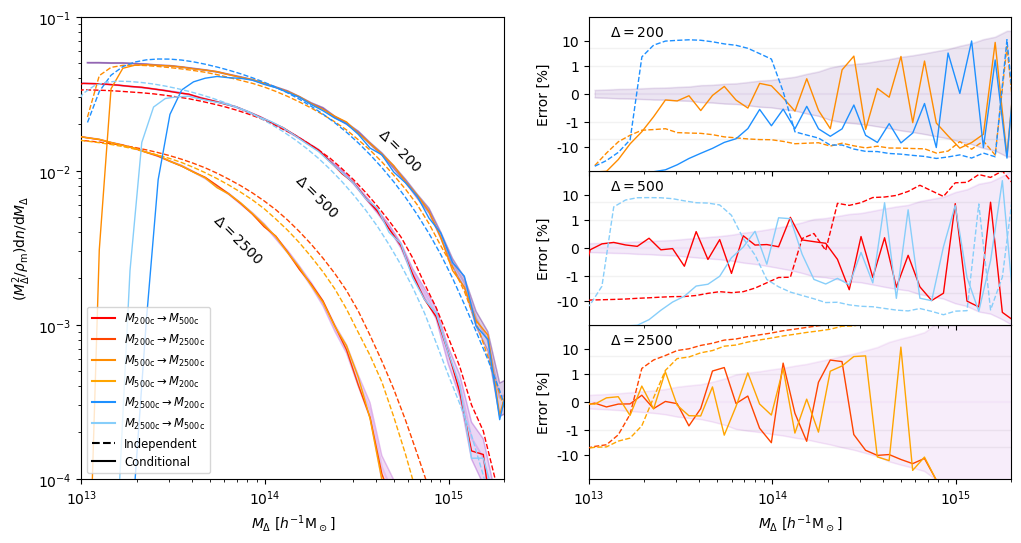

In [6]:
rho_m = Om * cosmo.rho_c(0) * 1e9 * (zs[snap_ind] + 1)**3 # going to need this

# The rest of this cell is just what it takes to make a nice-ish looking plot in matplotlib.

cols = ['red', 'orangered', 'darkorange', 'orange', 'dodgerblue', 'lightskyblue']
fig = plt.figure(constrained_layout=True, figsize = (12,6))
ax = fig.subplot_mosaic(
    """
    AADD
    AABB
    AACC
    """
)

# Just pre factors to make the plot nicer
fac1 = bins_200**2/rho_m
fac2 = bins_500**2/rho_m
fac3 = bins_2500**2/rho_m

# We first plot the reconstruction
ax["A"].loglog(z2,fac2 * rho_1to2_ind, c = cols[0], zorder = 10, lw = 1, ls = '--')
ax["A"].loglog(z2,fac2 * rho_1to2, c = cols[0], zorder = 10, lw = 1, ls = '-')

ax["A"].loglog(z3,fac3 * rho_1to3_ind, c = cols[1], zorder = 10, lw = 1, ls = '--')
ax["A"].loglog(z3,fac3 * rho_1to3, c = cols[1], zorder = 10, lw = 1, ls = '-')

ax["A"].loglog(z3,fac3 * rho_2to3_ind, c = cols[3], zorder = 10, lw = 1, ls = '--')
ax["A"].loglog(z3,fac3 * rho_2to3, c = cols[3], zorder = 10, lw = 1, ls = '-')

ax["A"].loglog(z1,fac1 * rho_2to1_ind, c = cols[2], zorder = 10, lw = 1, ls = '--')
ax["A"].loglog(z1,fac1 * rho_2to1, c = cols[2], zorder = 10, lw = 1, ls = '-')

ax["A"].loglog(z1,fac1 * rho_3to1_ind, c = cols[4], zorder = 10, lw = 1, ls = '--')
ax["A"].loglog(z1,fac1 * rho_3to1, c = cols[4], zorder = 10, lw = 1, ls = '-')

ax["A"].loglog(z2,fac2 * rho_3to2_ind, c = cols[5], zorder = 10, lw = 1, ls = '--')
ax["A"].loglog(z2,fac2 * rho_3to2, c = cols[5], zorder = 10, lw = 1, ls = '-')
lab =[r'$M_{200\mathrm{c}} \rightarrow M_{500\mathrm{c}}$',r'$M_{200\mathrm{c}} \rightarrow M_{2500\mathrm{c}}$',r'$M_{500\mathrm{c}} \rightarrow M_{2500\mathrm{c}}$',
      r'$M_{500\mathrm{c}} \rightarrow M_{200\mathrm{c}}$',r'$M_{2500\mathrm{c}} \rightarrow M_{200\mathrm{c}}$', r'$M_{2500\mathrm{c}} \rightarrow M_{500\mathrm{c}}$']
[ax["A"].plot([],[], c = cols[j], label = lab[j], ls = '-') for j in range(len(lab))];
ax["A"].plot([],[], 'k--', label = 'Independent')
ax["A"].plot([],[], 'k-', label = 'Conditional')

# Then we plot the data
ax["A"].loglog(bins_200,bins_200/rho_m*hmf_200, 'indigo', alpha = 0.2)
ax["A"].loglog(bins_200,bins_200/rho_m*(hmf_200 + err_200), 'indigo', lw = 1, alpha = 0.2)
ax["A"].loglog(bins_200,bins_200/rho_m*(hmf_200 - err_200), 'indigo', lw = 1, alpha = 0.2)
ax["A"].fill_between(bins_200,bins_200/rho_m*(hmf_200 - err_200),bins_200/rho_m*(hmf_200 + err_200), color = 'indigo', alpha = 0.2)

ax["A"].loglog(bins_500,bins_500/rho_m*(hmf_500), 'darkorchid', alpha = 0.2)
ax["A"].loglog(bins_500,bins_500/rho_m*(hmf_500 + err_500), 'darkorchid', lw = 1, alpha = 0.2)
ax["A"].loglog(bins_500,bins_500/rho_m*(hmf_500 - err_500), 'darkorchid', lw = 1, alpha = 0.2)
ax["A"].fill_between(bins_500,bins_500/rho_m*(hmf_500 - err_500),bins_500/rho_m*(hmf_500 + err_500), color ='darkorchid', alpha = 0.2)

ax["A"].loglog(bins_2500,bins_2500/rho_m*(hmf_2500), 'mediumorchid', alpha = 0.2)
ax["A"].loglog(bins_2500,bins_2500/rho_m*(hmf_2500 + err_2500), 'mediumorchid', lw = 1, alpha = 0.2)
ax["A"].loglog(bins_2500,bins_2500/rho_m*(hmf_2500 - err_2500), 'mediumorchid', lw = 1, alpha = 0.2)
ax["A"].fill_between(bins_2500,bins_2500/rho_m*(hmf_2500 - err_2500),bins_2500/rho_m*(hmf_2500 + err_2500), color ='mediumorchid', alpha = 0.2)


ax["A"].set_ylim(1e-4, 1e-1)
ax["A"].set_xlim(1e13, 2e15)
ax["A"].legend(fontsize = 'small').set_zorder(11)
ax["A"].set_ylabel(r"$(M_\Delta^2/\rho_\mathrm{m})\mathrm{d}n/\mathrm{d} M_{\Delta}$")
ax["A"].grid(False)
ax["A"].set_xlabel(r'$M_{\Delta}\ [h^{-1}\mathrm{M}_\odot$]')


# And now the errors on the reconstruction
ax["D"].plot(z1,(bins_200*rho_2to1_ind/hmf_200 - 1)*100, c = cols[2], zorder = 10, lw = 1, ls = '--')
ax["D"].plot(z1,(bins_200*rho_2to1/hmf_200 - 1)*100, c = cols[2], zorder = 10, lw = 1, ls = '-')
ax["D"].plot(z1,(bins_200*rho_3to1_ind/hmf_200 - 1)*100, c = cols[4], zorder = 10, lw = 1, ls ='--')
ax["D"].plot(z1,(bins_200*rho_3to1/hmf_200 - 1)*100, c = cols[4], zorder = 10, lw = 1, ls= '-')

y_200 = np.copy(hmf_200)
dy_200 = np.copy(err_200)
y_200[err_200 == 0] = 1
dy_200[err_200 == 0] = 1
ax["D"].plot(bins_200, np.zeros(hmf_200.size), 'indigo', alpha = 0.05)
ax["D"].plot(bins_200, (dy_200/y_200)*100, 'indigo', lw = 1, alpha = 0.05)
ax["D"].plot(bins_200, (- dy_200/y_200)*100, 'indigo', lw = 1, alpha = 0.05)
ax["D"].fill_between(bins_200, (- dy_200/y_200)*100, (dy_200/y_200)*100, color ='indigo', alpha = 0.1)


ax["B"].plot(z2,(bins_500*rho_1to2_ind/hmf_500 - 1)*100, c = cols[0], zorder = 10, lw = 1, ls = '--')
ax["B"].plot(z2,(bins_500*rho_1to2/hmf_500 - 1)*100, c = cols[0], zorder = 10, lw = 1, ls = '-')
ax["B"].plot(z2,(bins_500*rho_3to2_ind/hmf_500 - 1)*100, c = cols[5], zorder = 10, lw = 1, ls = '--')
ax["B"].plot(z2,(bins_500*rho_3to2/hmf_500 - 1)*100, c = cols[5], zorder = 10, lw = 1, ls= '-')
y_500 = np.copy(hmf_500)
dy_500 = np.copy(err_500)
y_500[err_500 == 0] = 1
dy_500[err_500 == 0] = 1
ax["B"].plot(bins_500, np.zeros(hmf_500.size), 'darkorchid', alpha = 0.05)
ax["B"].plot(bins_500, (dy_500/y_500)*100, 'darkorchid', lw = 1, alpha = 0.05)
ax["B"].plot(bins_500, (- dy_500/y_500)*100, 'darkorchid', lw = 1, alpha = 0.05)
ax["B"].fill_between(bins_500, (- dy_500/y_500)*100, (dy_500/y_500)*100, color ='darkorchid', alpha = 0.1)

ax["C"].plot(z3,(bins_2500*rho_1to3_ind/hmf_2500 - 1)*100, c = cols[1], zorder = 10, lw = 1, ls = '--')
ax["C"].plot(z3,(bins_2500*rho_2to3_ind/hmf_2500 - 1)*100, c = cols[3], zorder = 10, lw = 1, ls = '--')
ax["C"].plot(z3,(bins_2500*rho_1to3/hmf_2500 - 1)*100, c = cols[1], zorder = 10, lw = 1, ls = '-')
ax["C"].plot(z3,(bins_2500*rho_2to3/hmf_2500 - 1)*100, c = cols[3], zorder = 10, lw = 1, ls = '-')

x = np.hstack([bins_2500, 4e15])
dy = np.hstack([(- err_2500/hmf_2500)*100,-100])
dy[~np.isfinite(dy)] = -100

ax["C"].plot(x, np.zeros(x.size), 'mediumorchid', alpha = 0.05)
ax["C"].plot(x, dy, 'mediumorchid', lw = 1, alpha = 0.05)
ax["C"].plot(x, -dy, 'mediumorchid', lw = 1, alpha = 0.05)
ax["C"].fill_between(x, -dy, dy, color ='mediumorchid', alpha = 0.1)
ax["C"].set_xlim(bins_2500.min(), bins_2500.max())

#Finally label all the panels
for LAB in ["D", "C", "B"]:
    [ax[LAB].plot(bins_500, l*np.ones(bins_500.size), color ='k', alpha = 0.05, lw = 1) for l in [1,-1,5,-5]]
    ax[LAB].set_xscale('log')
    ax[LAB].grid(False)
    ax[LAB].set_ylabel(r"Error [%]")
    ax[LAB].set_xlim(1e13,2e15)
    ax[LAB].set_ylim(-90,90)
    ax[LAB].set_yscale('symlog',linthresh=1)
    ax[LAB].set_yticklabels(['-10', '-1', '0', '1', '10'])
    
ax["D"].set_xticklabels([])
ax["B"].set_xticklabels([])
ax["C"].set_xlabel(r'$M_{\Delta}\ [h^{-1}\mathrm{M}_\odot$]')
ax["D"].annotate(xy = (1.3e13, 15), text = r'$\Delta = 200$')
ax["B"].annotate(xy = (1.3e13, 15), text = r'$\Delta = 500$')
ax["C"].annotate(xy = (1.3e13, 15), text = r'$\Delta = 2500$')

if zf =='z0p00':
    ax["A"].annotate(xy = (4e14, 1e-2), rotation = -45, text = r'$\Delta = 200$')
    ax["A"].annotate(xy = (1.4e14, 5e-3), rotation = -45, text = r'$\Delta = 500$')
    ax["A"].annotate(xy = (5e13, 2.5e-3), rotation = -45, text = r'$\Delta = 2500$')
    
if zf =='z0p49':
    ax["A"].annotate(xy = (1.2e14, 7e-3), rotation = -45, text = r'$\Delta = 200$')
    ax["A"].annotate(xy = (8e13, 4.5e-3), rotation = -45, text = r'$\Delta = 500$')
    ax["A"].annotate(xy = (5e13, 2.5e-3), rotation = -45, text = r'$\Delta = 2500$')
    
if zf =='z1p03':
    ax["A"].annotate(xy = (1.4e14, 3e-3), rotation = -50, text = r'$\Delta = 200$')
    ax["A"].annotate(xy = (6.5e13, 1.4e-3), rotation = -55, text = r'$\Delta = 500$')
    ax["A"].annotate(xy = (5e13, 3e-4), rotation = -60, text = r'$\Delta = 2500$')

fig.subplots_adjust(hspace = 0, wspace = 0.5)
plt.savefig(f's_estimates_Uchuu_{zf}.pdf', bbox_inches = 'tight')

### Generating sparsity distributions from halo catalogues
The following cell shows how the sparsity distributions were generated from the Uchuu halo catalogues. It's purposefully been put as markdown as it will raise an error as I have not included the corresponding halo catalogues (they are too powerful). 

```
%%time

data_file = "./Uchuu_m200c_1e13.hdf5" # This file simply contains the Uchuu Rockstar catalogues for all haloes with masses M200c > 1e14 h^{-1}Msol
sparsity_file = "Uchuu_sparsity_distributions.hdf5"

def Uchuu_z_key(z):
    zf = 'z'+str(z).replace('.', 'p')
    while len(zf)<5:
        zf += '0'
    if len(zf) > 5:
        if int(zf[5]) > 4:
            zf = zf[:4] + str(int(zf[4]) + 1) +zf[5:]
        zf = zf[:5]
    return zf

zs = np.flip(np.array([2.03, 1.90, 1.77, 1.65, 1.54, 1.43, 1.32, 1.22, 1.12, 1.03, 0.94, 0.86, 0.78, 0.70, 0.63, 0.56, 0.49, 0.43, 0.36, 0.30, 0.25, 0.19, 0.14, 0.093, 0.045, 0.022, 0.0]))

with h5py.File(sparsity_file,'w') as out:
    
    out['/'].attrs.create('Omega_m', Om)
    out['/'].attrs.create('Omega_L', OL)
    out['/'].attrs.create('Omega_b', Ob)
    out['/'].attrs.create('sigma_8', sig8)
    out['/'].attrs.create('h', h)
    out['/'].attrs.create('ns', ns)
    for snap_ind in tqdm(range(len(zs))):
        zf = Uchuu_z_key(zs[snap_ind])
        with h5py.File(data_file,'r') as f:
            data = f[zf][:]
        nbins = 200
        s_bins = np.linspace(0,16,nbins)
        logM_bins = np.logspace(13,16,nbins)

        map_s_2_5_2 = np.zeros((nbins-1, nbins-1))
        map_s_2_25_2 = np.zeros((nbins-1, nbins-1))
        map_s_5_25_5 = np.zeros((nbins-1, nbins-1))
        map_s_2_5_5 = np.zeros((nbins-1, nbins-1))
        map_s_2_25_25 = np.zeros((nbins-1, nbins-1))
        map_s_5_25_25 = np.zeros((nbins-1, nbins-1))

        s200_500 = data['M200c']/data['M500c']
        s200_2500 = data['M200c']/data['M2500c']
        s500_2500 = data['M500c']/data['M2500c']

        logM_grid, s_grid = np.meshgrid(0.5*(logM_bins[1:]+logM_bins[:-1]),0.5*(s_bins[1:]+s_bins[:-1])) 
        points = np.stack([s_grid.flatten(), np.log10(logM_grid).flatten()]).T

        for i in range(nbins-1):
            cond = (data['M200c'] > logM_bins[i]) & (data['M200c'] <= logM_bins[i+1])
            map_s_2_5_2[i,:], bins = np.histogram(s200_500[cond], bins = s_bins, density = True)
            map_s_2_25_2[i,:], bins = np.histogram(s200_2500[cond], bins = s_bins, density = True)

            cond = (data['M500c'] > logM_bins[i]) & (data['M500c'] <= logM_bins[i+1])
            map_s_2_5_5[i,:], bins = np.histogram(s200_500[cond], bins = s_bins, density = True)
            map_s_5_25_5[i,:], bins = np.histogram(s500_2500[cond], bins = s_bins, density = True)

            cond = (data['M2500c'] > logM_bins[i]) & (data['M2500c'] <= logM_bins[i+1])
            map_s_2_25_25[i,:], bins = np.histogram(s200_2500[cond], bins = s_bins, density = True)
            map_s_5_25_25[i,:], bins = np.histogram(s500_2500[cond], bins = s_bins, density = True)

        map_s_2_5_2[~np.isfinite(map_s_2_5_2)] = 0
        map_s_2_25_2[~np.isfinite(map_s_2_25_2)] = 0

        map_s_2_5_5[~np.isfinite(map_s_2_5_5)] = 0
        map_s_5_25_5[~np.isfinite(map_s_5_25_5)] = 0

        map_s_2_25_25[~np.isfinite(map_s_2_25_25)] = 0
        map_s_5_25_25[~np.isfinite(map_s_5_25_25)] = 0

        out.create_dataset(f"/z{zs[snap_ind]}/bins/s", s_bins.shape, data = s_bins , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/bins/M", logM_bins.shape, data = logM_bins , dtype = np.float64)

        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_200,500|M_200)", map_s_2_5_2.shape, data = map_s_2_5_2 , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_200,2500|M_200)", map_s_2_25_2.shape, data = map_s_2_25_2 , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_200,500|M_500)", map_s_2_5_5.shape, data = map_s_2_5_5 , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_500,2500|M_500)", map_s_5_25_5.shape, data = map_s_5_25_5 , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_200,2500|M_2500)", map_s_2_25_25.shape, data = map_s_2_25_25 , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_500,2500|M_2500)", map_s_5_25_25.shape, data = map_s_5_25_25 , dtype = np.float64)
        
        rho_s, sbins = np.histogram(s200_500, bins = s_bins, density = True)
        rho_s2, sbins2 = np.histogram(s200_2500, bins = s_bins, density = True)
        rho_s3, sbins3 = np.histogram(s500_2500, bins = s_bins, density = True)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_200,500)", rho_s.shape, data = rho_s , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_200,2500)", rho_s2.shape, data = rho_s2 , dtype = np.float64)
        out.create_dataset(f"/z{zs[snap_ind]}/distributions/rho(s_500,2500)", rho_s3.shape, data = rho_s3 , dtype = np.float64)
```

# Transformations using a $c-M$ relation

In [7]:
# Let's rename the colossus function for simplicity
def c_M_z(M, z, model = 'ludlow16'):
    '''
    Concentration-Mass-redshift relations from collosus
    Parameters:
    ----------
    M: (array of floats) Halo mass M200c [h^{-1}Msol]
    z: (float) redshift
    model: (string) c-M relation model identifier, see colossus documentation for more information on possible models
    Outputs:
    ----------
    c: (array of floats) concentration mass relation evaluated at the desired point and redshift. 
    '''
    return concentration.concentration(M, '200c', z, model = model)

Deleted outdated persistence file, no further action needed.


Text(0, 0.5, '$c(M_{200 \\mathrm{c}},z = 0)$')

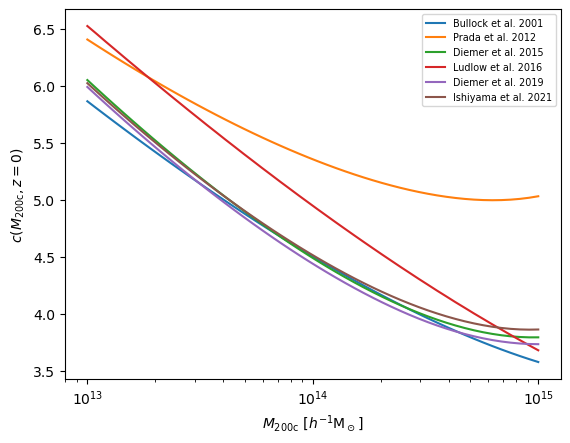

In [8]:
#Let's have a quick look at what we have in colossus...

models = ["bullock01", "prada12","diemer15", "ludlow16", "diemer19", "ishiyama21"]
labels = ["Bullock et al. 2001", "Prada et al. 2012","Diemer et al. 2015", "Ludlow et al. 2016", "Diemer et al. 2019", "Ishiyama et al. 2021"]

M = np.geomspace(1e13, 1e15, 50)

for i in range(len(models)):
    plt.plot(M,(c_M_z(M,0, models[i])), label = labels[i])
plt.legend(fontsize = 'x-small')
plt.xscale('log')
plt.xlabel(r'$M_{200 \mathrm{c}}\ [h^{-1}\mathrm{M}_\odot]$')
plt.ylabel(r'$c(M_{200 \mathrm{c}},z = 0)$')

In [9]:
# Let's set up all we're going to neeed to convert from concentration to sparsity an vice-versa

def sparsity(c, delta):
    '''
    Function returning the finding the root s_{200, delta} of Eq. (12) from the paper, given a value of the NFW concentration "c".
    For genereric sparsities s_{delta_1, delta_2} you can evalutate this function twice such that s_{delta_1, delta_2} = s_{200, delta_1}/s_{200, delta_2}.
    Here the root is found using scipy.optimize.root.
    Parameters:
    ----------
    c: (float) NFW concentration parameter
    delta: (float) second over density at which to evaluate the sparsity, s_{200, delta}
    Outputs:
    ----------
    s200_delta: (float) NFW sparsity coresponding to the concentration 
    '''
    x = root(lambda x: (np.log(1+c*x) - c*x/(1 + c*x))/(np.log(1+c) - c/(1+c)) - x**3*delta/200, x0 = 1.5)['x']
    return 200/x**3/delta

def Newton_Raphson(f, xi, dx, tol, verbose = False, *args, **kwargs): 
    '''
    This is the standard Newton-Raphson root finder "borrowed" from Numerical Recipes Vol.III
    Parameters:
    ----------
    f: (callable) 1 parameter function to optmize
    xi: (float) starting position
    dx: (float) spacing used to numerically compute derivatives
    tol: (float) absolute tolerance criterion
    Outputs:
    ----------
    xi_1: (float) root of f
    '''
    xi_1 = xi
    Dx = tol * 1e3
    it_num = 0
    while Dx > tol:
        xi = xi_1
        xi_1 = xi - dx * f(xi, *args)/(f(xi + dx, *args) - f(xi, *args))
        Dx = np.abs(xi - xi_1)
        if verbose:
            print(xi, end= ' ')
        if it_num >= 500:
            raise ValueError("The root search has not converged after 500 itterations")
    if verbose:
        print("root: ", xi_1, end= '\n')
    return xi_1

def Newton_Raphson_vec(f, xi, dx, tol, output_issues = False, verbose = False, *args, **kwargs):
    '''
    This is the standard Newton-Raphson root finder "borrowed" from Numerical Recipes Vol.III
    This is the same as the previous function but vectorised for SPEEED. Carefull however, as it will however not raise an error when it has failed to converge!
    Parameters:
    ----------
    f: (callable) 1 parameter function to optmize
    xi: (float) starting position
    dx: (float) spacing used to numerically compute derivatives
    tol: (float) absolute tolerance criterion
    Outputs:
    ----------
    xi_1: (float) root of f
    '''
    size = f(xi).size
    xi = xi*np.ones(size)
    xi_1 = np.copy(xi)
    Dx = tol * 1e3
    it_num = 0
    while np.any(Dx > tol):
        xi = xi_1
        xi_1 = xi - dx * f(xi, *args)/(f(xi + dx, *args) - f(xi, *args))
        Dx = np.abs(xi - xi_1)
        if verbose:
            print(xi, end= ' ')
        it_num += 1
        if it_num >= 500:
            if verbose:
                print(f"the algorithm has not converged after 500 iterations for {np.where(Dx > tol)[0].size} value(s):\nIndices where the algorithm didn't converge {np.where(Dx > tol)[0]}", flush = True)
            break
    if verbose:
        print("root: ", xi_1, end= '\n', flush = True)
    if output_issues:
        return xi_1, np.where(Dx > tol)[0]
    else:
        return xi_1

def s_of_c(c, delta, **kwargs):
    '''
    Function returning the finding the root s_{200, delta} of Eq. (12) from the paper, given a value of the NFW concentration "c".
    For genereric sparsities s_{delta_1, delta_2} you can evalutate this function twice such that s_{delta_1, delta_2} = s_{200, delta_1}/s_{200, delta_2}.
    Here the root is computed using the Newton-Raphson algorithm.
    Parameters:
    ----------
    c: (float) NFW concentration parameter
    delta: (float) second over density at which to evaluate the sparsity, s_{200, delta}
    Outputs:
    ----------
    s200_delta: (float) NFW sparsity coresponding to the concentration 
    '''
    g = lambda x, c, delta: delta/200*x**3 - (np.log(1+c*x) - c*x/(1+c*x))/(np.log(1+c) - c/(1+c))
    args = (c, delta)
    x = Newton_Raphson(g, 1, 1e-5, 1e-6, *args, **kwargs)
    return 200 / x**3 /delta

def c_of_s(s, delta, **kwargs):
    '''
    Function returning the finding the root c of Eq. (12) from the paper, given a value of the sparsity "s_{200,delta}".
    Here the root is found using the Newton-Raphson algorithm.
    Parameters:
    ----------
    s: (float) sparsity s_{200,delta}
    delta: (float) second over density at which to evaluate the sparsity, s_{200, delta}
    Outputs:
    ----------
    c: (float) NFW concetration coresponding to the sparsity 
    '''
    x = (delta/200*s)**(-1/3)
    g = lambda c, x, delta: delta/200*x**3 - (np.log(1+c*x) - c*x/(1+c*x))/(np.log(1+c) - c/(1+c))
    args = (x, delta)
    c = Newton_Raphson(g, 1, 1e-5, 1e-6, *args, **kwargs)
    return c

def S_OF_C(c, delta, **kwargs):
    '''
    Vectorised form of s_of_c, note that delta and c have to either be the same size or delta must be a float.
    Parameters:
    ----------
    c: (array of floats) NFW concentration parameter
    delta: (array of floats) second over density at which to evaluate the sparsity, s_{200, delta}
    Outputs:
    ----------
    s200_delta: (array of float) NFW sparsity coresponding to the concentration 
    '''
    g = lambda x, c, delta: delta/200*x**3 - (np.log(1+c*x) - c*x/(1+c*x))/(np.log(1+c) - c/(1+c))
    args = (c, delta)
    x = Newton_Raphson_vec(g, np.ones(c.size), 1e-5, 1e-6, *args, **kwargs)
    return 200 / x**3 /delta

def C_OF_S(s, delta, **kwargs):
    '''
    Vectorised form of c_of_s, note that delta and s have to either be the same size or delta must be a float.
    Parameters:
    ----------
    s: (float) sparsity s_{200,delta}
    delta: (float) second over density at which to evaluate the sparsity, s_{200, delta}
    Outputs:
    ----------
    c: (float) NFW concetration coresponding to the sparsity 
    '''
    x = (delta/200*s)**(-1/3)
    g = lambda c: delta/200*x**3 - (np.log(1+c*x) - c*x/(1+c*x))/(np.log(1+c) - c/(1+c))
    #args = (x, delta)
    c = Newton_Raphson_vec(g, np.ones(x.size), 1e-5, 1e-6, **kwargs)
    return c

def log_normal(x,mu,sigma):
    '''
    Log-normal distribution function.
    Parameters:
    ----------
    x: (array of floats) points at which to evaluate the distribution
    mu: (float) "position" parameter of the lognormal distribution != mean
    sigma: (float) "scale" parameter of the lognormal distirbution != standard deviation
    Outputs:
    ----------
    rho: (array of float) distribution evaluated at the desired points
    '''
    return 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/2/sigma**2)

def grad_C_OF_S(s,ds,delta):
    '''
    Vectorised numerical gradient of c_of_s, note that delta and s have to either be the same size or delta must be a float.
    Parameters:
    ----------
    s: (array of float) sparsity s_{200,delta}
    ds: (float) spacing used to numerically compute derivatives
    delta: (float) second over density at which to evaluate the sparsity, s_{200, delta}
    Outputs:
    ----------
    c: (float) NFW concetration coresponding to the sparsity 
    '''
    return (C_OF_S(s+ds, delta) - C_OF_S(s-ds, delta))/2/ds

def rho_s_of_c(s,M,z = 0, model = 'ludlow16'):
    '''
    Distribution of NFW sparsities assuming a concentration mass relation.
    Parameters:
    ----------
    s: (array of float) sparsity s_{200,500} at which the distribution is evalutated.
    M: (float) Halo mass M200c [h^{-1}Msol]
    z: (float) redshift
    model: (string) c-M relation model identifier, see colossus documentation for more information on possible models
    Outputs:
    ----------
    rho_s: (array) distribution evaluated at the desired points
    '''
    c = c_M_z(M,z, model = model)
    mu = np.log(c)
    sig_c = 0.25
    mu = np.log(c) - 0.5*sig_c**2
    rho_s = log_normal(C_OF_S(s,500),mu,sig_c)*np.abs(grad_C_OF_S(s, 1e-4, 500))
    rho_s[~np.isfinite(rho_s)] = 0
    return rho_s


In [10]:
%%time
# Now let's calculate the reconstruction assuming all the c-M models listed above. Again the notation breaks down here
y = np.logspace(0,1, 300)
z = bins_500
rho_rat_ind = np.zeros(z.size)
rho_rat_dep = np.zeros(z.size)
rho_rat_from_c = np.zeros(z.size)

for i in tqdm(range(len(z))):
    rho_rat_ind[i] =  simps( y* 10**(pdf_s(np.log10(y))+dn_dM(np.log10(z[i]*y))),y)
    
    rho_s_cond = griddata(points, map_s_2_5_2.T.flatten(), (y, np.log10(z[i]*y)), method='linear')
    rho_s_cond[~np.isfinite(rho_s_cond)] = 0
    rho_rat_dep[i] =  simps( y*rho_s_cond* 10**(dn_dM(np.log10(z[i]*y))),y)
    
    ## These lines can be used only if you specify a distribution of sparsities estimated from concentration and turn into a 2D map as above.
    #rho_c_cond = griddata(points_c, map_s_from_c.T.flatten(), (y, np.log10(z[i]*y)), method='linear')
    #rho_c_cond[~np.isfinite(rho_c_cond)] = 0
    #rho_rat_from_c[i] =  simps( y*rho_c_cond* 10**(dn_dM(np.log10(z[i]*y))),y)


rho_rat_mod = np.zeros((z.size, len(models)))
for j in range(len(models)):
    print(models[j], end = ' ')
    for i in range(len(z)):
        rho_rat_mod[i,j] =  simps( y* (rho_s_of_c(y,z[i]*y, model = models[j])*10**(dn_dM(np.log10(z[i]*y)))),y) # Eq. (17)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:54<00:00,  1.41s/it]


bullock01 prada12 diemer15 ludlow16 diemer19 ishiyama21 CPU times: user 1min 8s, sys: 20.1 s, total: 1min 28s
Wall time: 1min


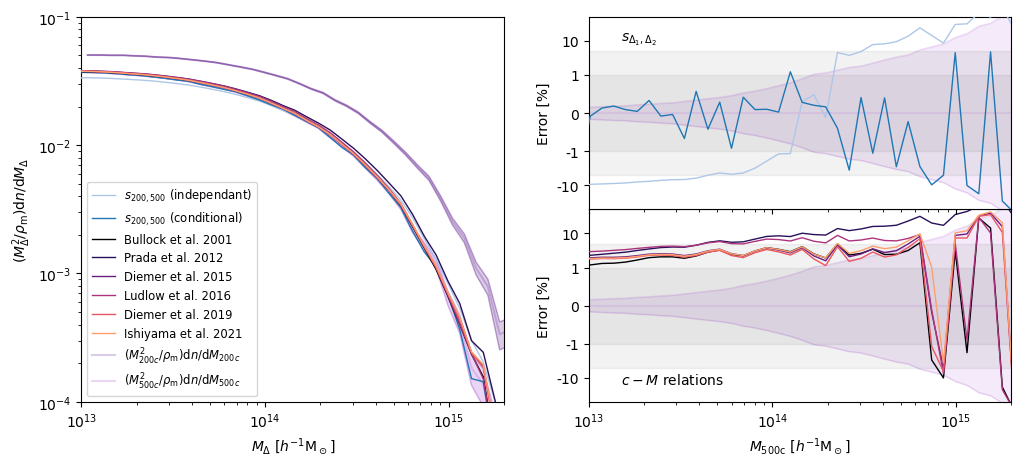

In [11]:
# Again here it's just plotting everything together

fig = plt.figure(constrained_layout=True, figsize = (12,5))
ax = fig.subplot_mosaic(
    """
    AB
    AB
    AC
    AC
    """
)
hmf_colours = ['indigo', "darkorchid"]
colours = cm.magma(np.linspace(0,0.8,len(models)))
markers = ['o', 'v', 'x', '+', '*', '^', 's']

rho_m = Om * cosmo.rho_c(0) * 1e9 * (zs[snap_ind] + 1)**3 
fac_200 = bins_200/rho_m
fac = bins_500/rho_m
z = bins_500

ax["A"].loglog(z,fac * bins_500*rho_rat_ind, zorder = 10, label = '$s_{200,500}$ (independant)', lw = 1, c = cm.tab20(0.05))
ax["A"].loglog(z,fac * bins_500*rho_rat_dep, zorder = 10, label = '$s_{200,500}$ (conditional)', lw = 1, c = cm.tab20(0.))
#ax["A"].loglog(z,fac * bins_500*rho_rat_from_c, zorder = 10, label = '$s_{200,500}$ (from c)', lw = 1, c = 'k')
for j in range(len(models)):
    ax["A"].loglog(z,fac * bins_500*rho_rat_mod[:,j], zorder = 10, label = labels[j], lw = 1, c = colours[j])



ax["A"].loglog(bins_200, fac_200 * hmf_200, hmf_colours[0], label = r'$(M_{200c}^2/\rho_\mathrm{m})\mathrm{d}n/\mathrm{d} M_{200c}$', alpha = 0.2)
ax["A"].loglog(bins_200, fac_200 * (hmf_200 + err_200),hmf_colours[0] , lw = 1, alpha = 0.2)
ax["A"].loglog(bins_200, fac_200 * (hmf_200 - err_200),hmf_colours[0] , lw = 1, alpha = 0.2)
ax["A"].fill_between(bins_200, fac_200 * (hmf_200 - err_200), fac_200 * (hmf_200 + err_200), color = hmf_colours[0], alpha = 0.2)

ax["A"].loglog(bins_500,fac * (hmf_500), hmf_colours[1], label = r'$(M_{500c}^2/\rho_\mathrm{m})\mathrm{d}n/\mathrm{d} M_{500c}$', alpha = 0.2)
ax["A"].loglog(bins_500,fac * (hmf_500 + err_500), hmf_colours[1], lw = 1, alpha = 0.2)
ax["A"].loglog(bins_500,fac * (hmf_500 - err_500), hmf_colours[1], lw = 1, alpha = 0.2)
ax["A"].fill_between(bins_500,fac * (hmf_500 - err_500),fac * (hmf_500 + err_500), color = hmf_colours[1], alpha = 0.2)


ax["A"].set_ylim(1e-4, 1e-1)
ax["A"].set_xlim(1e13, 2e15)
ax["A"].legend(fontsize = 'small')
ax["A"].set_ylabel(r"$(M_\Delta^2/\rho_\mathrm{m})\mathrm{d}n/\mathrm{d} M_{\Delta}$")

ax["A"].grid(False)
ax["A"].set_xlabel(r'$M_{\Delta}\ [h^{-1}\mathrm{M}_\odot$]')


ax["B"].plot(z,(bins_500*rho_rat_ind/hmf_500 - 1)*100, zorder = 10, label = '$s_{200,500}$ (independant)', c = cm.tab20(0.05), lw = 1)
ax["B"].plot(z,(bins_500*rho_rat_dep/hmf_500 - 1)*100, zorder = 10, label = '$s_{200,500}$ (conditional)', c = cm.tab20(0.), lw = 1)
ax["B"].plot(z,(bins_500*rho_rat_from_c/hmf_500 - 1)*100, zorder = 10, label = '$s_{200,500}$ (conditional)', c = 'k', lw = 1)
for j in range(len(models)):
    ax["C"].plot(z,(bins_500*rho_rat_mod[:,j]/hmf_500 - 1)*100, zorder = 10, label = models[j], lw = 1, c = colours[j])

for LAB in ["B", "C"]:
    ax[LAB].plot(bins_500, np.zeros(hmf_500.size), hmf_colours[1], alpha = 0.1)
    ax[LAB].plot(bins_500, (err_500/hmf_500)*100, hmf_colours[1], lw = 1, alpha = 0.1)
    ax[LAB].plot(bins_500, (- err_500/hmf_500)*100, hmf_colours[1], lw = 1, alpha = 0.1)
    ax[LAB].fill_between(bins_500, (- err_500/hmf_500)*100, (err_500/hmf_500)*100, color =hmf_colours[1], alpha = 0.1)

    ax[LAB].fill_between(bins_500, -5*np.ones(bins_500.size), 5*np.ones(bins_500.size), color ='k', alpha = 0.05)
    ax[LAB].fill_between(bins_500, -1*np.ones(bins_500.size), 1*np.ones(bins_500.size), color ='k', alpha = 0.05)
    ax[LAB].set_xlim(bins_500.min(), bins_500.max())
    ax[LAB].set_xscale('log')
    ax[LAB].grid(False)

    
    ax[LAB].set_ylabel(r"Error [%]")
    ax[LAB].set_xlim(1e13,2e15)
    ax[LAB].set_ylim(-50,50)
    ax[LAB].set_yscale('symlog',linthresh=1)
    ax[LAB].set_yticklabels(['-10', '-1', '0', '1', '10'])
ax["B"].set_xticklabels([])
ax["C"].set_xlabel(r'$M_{500\mathrm{c}}\ [h^{-1}\mathrm{M}_\odot$]')
ax["B"].annotate(xy = (1.5e13, 10), text = r'$s_{\Delta_1,\Delta_2}$')
ax["C"].annotate(xy = (1.5e13, -15), text = r'$c-M$ relations')
fig.subplots_adjust(hspace = 0)
plt.savefig('s_and_c_estimates.pdf', bbox_inches = 'tight')

# Predicting the Sparsity

Now let's see how we can predict the sparsity distribution. Here we're going to present 3 methods. Twice, assuming the distribution of sparsity is highly peaked and solving either Eq. (7) or Eq. (24). And then assuming the sparsity distribution is Gaussian, and simultaneously solving Eq. (4) and Eq. (5).

In [12]:
# To predict the sparsity from the mass function, we're going to need two things... The mass function obviously...

def dn_dMDelta(M,z,Delta, method = "despali16"):
    '''
    Halo Mass Function, dn/dM, defined at the density contrast Delta.
    Parameters:
    ----------
    M: (Array of floats) Halo mass M_Delta [h^{-1}Msol]
    z: (float) redshift
    Delta: (float) Density contrast of the desired mass definition.
    model: (string) halo mass function model identifier, see colossus documentation for more information on possible models
    Outputs:
    ----------
    dn_dM: (array) halo mass function evaluated at the desired points
    '''
    return 1/M * mass_function.massFunction(M, z, mdef = str(Delta)+'c', model = method, q_in = 'M', q_out = 'dndlnM')

# And a function that calculates the residuals of Eq. (4) and Eq. (5) assuming the distribution of sparsities is Gaussian. 
# To get everything going a bit faster we also calulate the analytical jacobian with respect to the mean and standard deviation. 

def eq_sys_m_dependent_gauss_with_jac(x, M_mes, z):
    '''
    Function evaluating the square residuals of Eq. (4) and Eq. (5) assuming the sparsity distribution is Gaussian,
    as well as the local jacobian with respect to the mean and standard deviation of said Gaussian distribution. 
    This function is to be passed to scipy.optimize.root to find the pair of parameters x which simultaneously solve Eq. (4) and Eq. (5).
    Parameters:
    ----------
    x: (size (2,) tuple of floats) pair of mean and standard deviation parameters for which we want to evaluate the relations
    M_mes: (float) Halo mass M_500 [h^{-1}Msol]
    z: (float) redshift
    Outputs:
    ----------
    dn_dM: (array) halo mass function evaluated at the desired points
    '''
    mu, sig = x
    y = np.logspace(0,2,300)

    rho_loc = st.norm.pdf(y, mu, sig)

    drho_dmu = (y-mu)/sig/sig * rho_loc
    drho_dsig = rho_loc * ((y - mu)*(y - mu)/sig/sig/sig - 1/sig)

    dn_num_in = dn_dMDelta(y*M_mes, z = z, Delta = 200, method = "despali16")
    dn_num_out = dn_dMDelta(M_mes/y, z = z, Delta = 500, method = "despali16")
    cond_in = np.isfinite(dn_num_in)
    cond_out = np.isfinite(dn_num_out)
    numer_in = trapz((y*rho_loc * dn_num_in)[cond_in] ,y[cond_in])
    numer_out = trapz((1/y*rho_loc * dn_num_out)[np.isfinite(dn_num_out)] ,y[np.isfinite(dn_num_out)])

    denom_in = dn_dMDelta(M_mes, z = z, Delta = 500, method = "despali16")
    denom_out = dn_dMDelta(M_mes, z = z, Delta = 200, method = "despali16")

    dnumer_dmu_in = trapz((y*drho_dmu * dn_num_in)[cond_in] ,y[cond_in])
    dnumer_dsig_in = trapz((y*drho_dsig * dn_num_in)[cond_in] ,y[cond_in])
    dnumer_dmu_out = trapz((1/y*drho_dmu * dn_num_out)[cond_out] ,y[cond_out])
    dnumer_dsig_out = trapz((1/y*drho_dsig * dn_num_out)[cond_out] ,y[cond_out])

    r_in = numer_in/denom_in
    r_out = numer_out/denom_out

    jac = -np.array([[2/denom_in * dnumer_dmu_in * (1 - r_in), 2/denom_in * dnumer_dsig_in * (1 - r_in)],
                    [2/denom_out * dnumer_dmu_out * (1 - r_out), 2/denom_out * dnumer_dsig_out * (1 - r_out)]])

    return [(1 - r_in)**2, (1 - r_out)**2], jac

In [13]:
%%time

# Now lets solve this!!!
# As always let's set up some stuff...

nbins = 100
tol = 1e-4

M500_bins = np.geomspace(1e13,2e15,nbins) # We're going to predict the sparsity distribution for this grid of masses M500c

# To have a point of reference let's calculate the mean and variance of spasity distibution in Uchuu...
mean_s = np.zeros(len(M_bins_cent))
std_s = np.zeros(len(M_bins_cent))


M_pred = np.zeros((len(M500_bins)-1, 2))
M_pred1d = np.zeros((len(M500_bins)-1,2))

for i in range(len(M_bins_cent)): 
    # ... by numerically evaluating integral which is not the safest way of doing so but we don't have a choice.
    # This makes the figure look different from Fig. (5) as in that figure we're looking at the sparsity sample mean and unbiased sample variance.
    mean_s[i] = simps(s_bins_cent*map_s_2_5_2[i,:], s_bins_cent)
    std_s[i] = np.sqrt(simps(s_bins_cent**2*map_s_2_5_2[i,:], s_bins_cent) - mean_s[i]**2)
    
for i in tqdm(range(len(M500_bins)-1)):
    M_500 = 0.5*(M500_bins[i] + M500_bins[i+1])
    
    # Let's predict the mean sparsity assuming the distribution is highly peaked.
    # First let's solve Eq. (7), so we set up a lambda expresion that evaluates the residuals of Eq. (7) and feed it to a root finder
    f_local_inward = lambda s, M_500, z: s*dn_dMDelta(s*M_500, z = z, Delta = 200, method = "despali16") - dn_dMDelta(M_500, z = z, Delta = 500, method = "despali16")
    r = root(f_local_inward , x0 = 1.35, args = (M_500, 0), tol = 1e-4)
    M_pred1d[i,0] = r['x']
    
    # Now let's solve Eq. (24), so we set up a lambda expresion that evaluates the residuals of Eq. (24) and feed it to a root finder
    f_local_outward = lambda s, M_500, z: dn_dMDelta(M_500, z = z, Delta = 200, method = "despali16") - 1/s*dn_dMDelta(M_500/s, z = z, Delta = 500, method = "despali16")
    r = root(f_local_outward , x0 = 1.35, args = (M_500, 0), tol = 1e-4) # Nom nom nom
    M_pred1d[i,1] = r['x']
    
    # Finally lets simultaneously solve Eq. (4) and Eq. (5) to get both the mean and standard deviation of the distribution.
    try:
        r = root(eq_sys_m_dependent_gauss_with_jac , x0 = (1.35, 0.3), args = (M_500, 0), tol = tol, jac = True, method = 'lm')
        if r['success']:
            M_pred[i,:] = r['x']
        else:
            M_pred[i,:] = np.nan   
    except ValueError:
        M_pred[i,:] = np.nan
        continue
    

        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:06<00:00, 15.10it/s]

CPU times: user 6.76 s, sys: 91.9 ms, total: 6.85 s
Wall time: 6.61 s


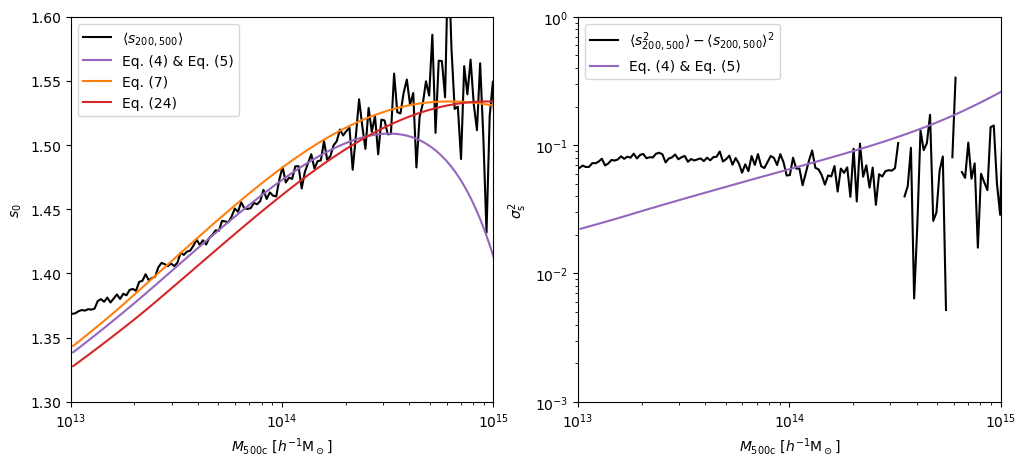

In [14]:
# Let's make a simple plot to compare our predictions with the measurements from the distributions.

colours = ['k', 'tab:purple', 'tab:orange', 'tab:red']

m500_cent = 0.5*(M500_bins[1:] + M500_bins[:-1])

fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].plot(M_bins_cent, mean_s, label = r"$\langle s_{200,500} \rangle$", c = colours[0])
ax[0].plot(m500_cent, M_pred[:,0], label = "Eq. (4) & Eq. (5)", c = colours[1])
ax[0].plot(m500_cent, M_pred1d[:,0], label = "Eq. (7)" , c = colours[2])
ax[0].plot(m500_cent, M_pred1d[:,1], label = "Eq. (24)" , c = colours[3])

ax[1].plot(M_bins_cent, (std_s**2), label = r"$\langle s_{200,500}^2 \rangle - \langle s_{200,500}\rangle^2$", c = colours[0])
ax[1].plot(m500_cent, M_pred[:,1]**2, label = "Eq. (4) & Eq. (5)" , c = colours[1])

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_xlim(1e13, 1e15)
    ax[i].grid(False)
    ax[i].set_xlabel('$M_{500 \mathrm{c}}\ [h^{-1}\mathrm{M}_\odot]$')
    ax[i].legend()
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3,1)
ax[0].set_ylim(1.3,1.6)

ax[0].set_ylabel(r'$s_0$')
ax[1].set_ylabel(r'$\sigma_\mathrm{s}^2$')
fig.savefig('mean_and_var_predictions.pdf', bbox_inches = 'tight')

Text(0, 0.5, '$s_{200,500}$')

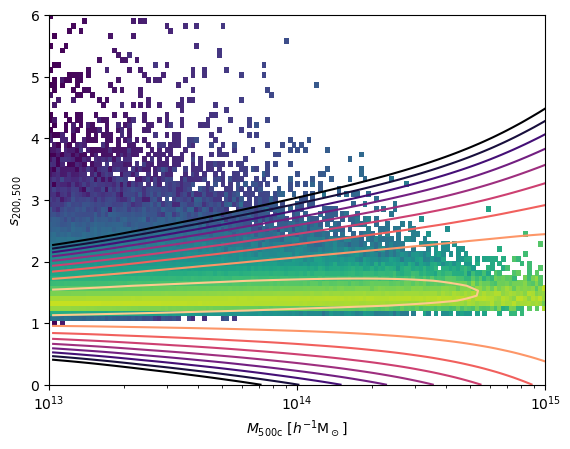

In [15]:
# We can also have a look at the distributions in two dimensions, i.e. in the sparsity-mass plane. 
# We can see that the recovered sparssity distribution is not great, as the assumed gaussian distribution doesn't capture the skewness.

rec_map = np.zeros((M_pred.shape[0],s_bins.size))

for i in range(M_pred.shape[0]):
    rec_map[i,:] = st.norm.pdf(s_bins, M_pred[i,0],  M_pred[i,1])
    
plt.pcolormesh(M_bins, s_bins, np.log10(map_s_2_5_5.T))

plt.contour(m500_cent, s_bins, np.log10(rec_map.T), cmap = 'magma', levels = np.arange(-8,2))
plt.xscale('log')
plt.ylim(0,6)
plt.xlim(1e13,1e15)
plt.xlabel(r'$M_{500\mathrm{c}}\ [h^{-1}\mathrm{M}_\odot]$')
plt.ylabel(r'$s_{200,500}$')